# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

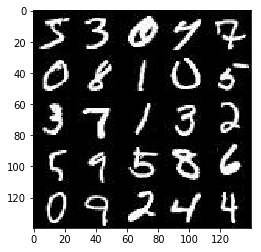

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

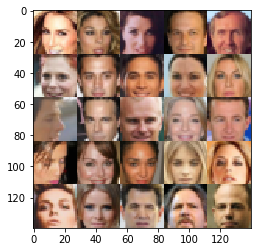

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/Users/sunweihao/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, ())
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 2x2x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    print_every = 10
    show_every = 100
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                #print(type(batch_images), type(batch_z), type(learning_rate))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5625... Generator Loss: 0.3585
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 1.6104
Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 1.5833
Epoch 1/2... Discriminator Loss: 0.2226... Generator Loss: 2.3299
Epoch 1/2... Discriminator Loss: 0.3164... Generator Loss: 1.9327
Epoch 1/2... Discriminator Loss: 0.1718... Generator Loss: 2.4410
Epoch 1/2... Discriminator Loss: 0.2360... Generator Loss: 2.7922
Epoch 1/2... Discriminator Loss: 0.2034... Generator Loss: 2.7571
Epoch 1/2... Discriminator Loss: 0.1844... Generator Loss: 2.9484


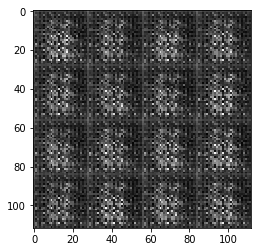

Epoch 1/2... Discriminator Loss: 0.4532... Generator Loss: 1.6207
Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 1.4591
Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 1.2816
Epoch 1/2... Discriminator Loss: 0.3415... Generator Loss: 1.8473
Epoch 1/2... Discriminator Loss: 0.5180... Generator Loss: 1.8211
Epoch 1/2... Discriminator Loss: 0.3078... Generator Loss: 2.1233
Epoch 1/2... Discriminator Loss: 0.2508... Generator Loss: 3.5226
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 1.2246
Epoch 1/2... Discriminator Loss: 0.1869... Generator Loss: 2.7961
Epoch 1/2... Discriminator Loss: 0.2633... Generator Loss: 2.3357


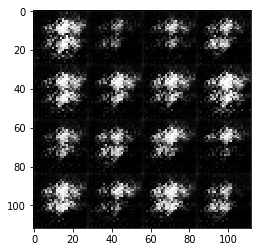

Epoch 1/2... Discriminator Loss: 0.2799... Generator Loss: 2.1394
Epoch 1/2... Discriminator Loss: 0.2486... Generator Loss: 2.6125
Epoch 1/2... Discriminator Loss: 0.1763... Generator Loss: 2.6857
Epoch 1/2... Discriminator Loss: 0.2748... Generator Loss: 2.3114
Epoch 1/2... Discriminator Loss: 0.2126... Generator Loss: 2.8116
Epoch 1/2... Discriminator Loss: 0.2207... Generator Loss: 2.5011
Epoch 1/2... Discriminator Loss: 0.1270... Generator Loss: 2.8793
Epoch 1/2... Discriminator Loss: 0.1985... Generator Loss: 2.5476
Epoch 1/2... Discriminator Loss: 0.1993... Generator Loss: 2.7039
Epoch 1/2... Discriminator Loss: 0.1469... Generator Loss: 3.0676


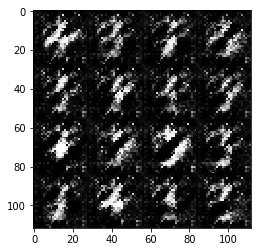

Epoch 1/2... Discriminator Loss: 0.1153... Generator Loss: 3.7011
Epoch 1/2... Discriminator Loss: 0.2427... Generator Loss: 2.2554
Epoch 1/2... Discriminator Loss: 0.2010... Generator Loss: 3.6644
Epoch 1/2... Discriminator Loss: 0.1385... Generator Loss: 3.2462
Epoch 1/2... Discriminator Loss: 0.1153... Generator Loss: 3.0630
Epoch 1/2... Discriminator Loss: 0.0908... Generator Loss: 3.0615
Epoch 1/2... Discriminator Loss: 0.2004... Generator Loss: 2.9609
Epoch 1/2... Discriminator Loss: 0.0799... Generator Loss: 5.9579
Epoch 1/2... Discriminator Loss: 0.2200... Generator Loss: 2.1293
Epoch 1/2... Discriminator Loss: 0.8532... Generator Loss: 0.7740


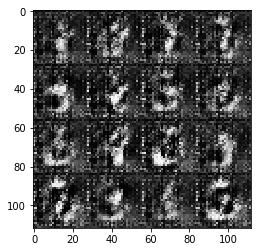

Epoch 1/2... Discriminator Loss: 0.2156... Generator Loss: 2.6505
Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 1.7781
Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 1.6390
Epoch 1/2... Discriminator Loss: 2.2983... Generator Loss: 0.1829
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.6146
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.9482
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 1.1995
Epoch 1/2... Discriminator Loss: 0.5883... Generator Loss: 1.4733
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 1.3102
Epoch 1/2... Discriminator Loss: 0.5338... Generator Loss: 1.3062


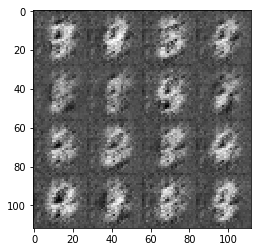

Epoch 1/2... Discriminator Loss: 0.4377... Generator Loss: 2.2270
Epoch 1/2... Discriminator Loss: 0.3369... Generator Loss: 1.9294
Epoch 1/2... Discriminator Loss: 0.3852... Generator Loss: 1.9927
Epoch 1/2... Discriminator Loss: 0.3356... Generator Loss: 2.3265
Epoch 1/2... Discriminator Loss: 0.3093... Generator Loss: 2.3229
Epoch 1/2... Discriminator Loss: 0.5044... Generator Loss: 1.2061
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 0.2939... Generator Loss: 2.0490
Epoch 1/2... Discriminator Loss: 0.2812... Generator Loss: 2.4335
Epoch 1/2... Discriminator Loss: 0.2789... Generator Loss: 2.2983


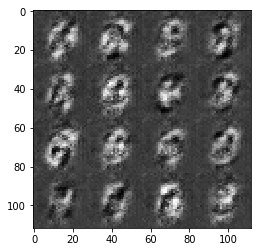

Epoch 1/2... Discriminator Loss: 0.3415... Generator Loss: 1.6039
Epoch 1/2... Discriminator Loss: 0.2047... Generator Loss: 2.4153
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 1.3872
Epoch 1/2... Discriminator Loss: 0.2184... Generator Loss: 2.5530
Epoch 1/2... Discriminator Loss: 0.3495... Generator Loss: 1.8019
Epoch 1/2... Discriminator Loss: 0.3099... Generator Loss: 1.9068
Epoch 1/2... Discriminator Loss: 0.3110... Generator Loss: 2.5786
Epoch 1/2... Discriminator Loss: 0.3115... Generator Loss: 2.8298
Epoch 1/2... Discriminator Loss: 0.2039... Generator Loss: 2.6550
Epoch 1/2... Discriminator Loss: 0.2252... Generator Loss: 2.2091


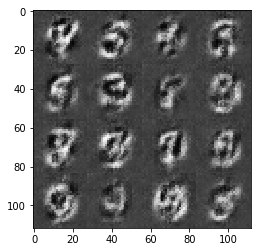

Epoch 1/2... Discriminator Loss: 0.1922... Generator Loss: 2.4202
Epoch 1/2... Discriminator Loss: 0.3040... Generator Loss: 2.0395
Epoch 1/2... Discriminator Loss: 0.1714... Generator Loss: 2.7737
Epoch 1/2... Discriminator Loss: 0.1481... Generator Loss: 2.9835
Epoch 1/2... Discriminator Loss: 0.1437... Generator Loss: 3.2828
Epoch 1/2... Discriminator Loss: 0.2536... Generator Loss: 1.9478
Epoch 1/2... Discriminator Loss: 0.2750... Generator Loss: 1.6930
Epoch 1/2... Discriminator Loss: 0.3952... Generator Loss: 1.3966
Epoch 1/2... Discriminator Loss: 0.2595... Generator Loss: 2.2362
Epoch 1/2... Discriminator Loss: 0.2206... Generator Loss: 2.3416


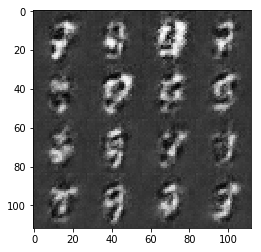

Epoch 1/2... Discriminator Loss: 0.1606... Generator Loss: 2.6500
Epoch 1/2... Discriminator Loss: 0.1437... Generator Loss: 2.9103
Epoch 1/2... Discriminator Loss: 0.1483... Generator Loss: 3.2033
Epoch 1/2... Discriminator Loss: 0.6422... Generator Loss: 4.7071
Epoch 1/2... Discriminator Loss: 0.1910... Generator Loss: 2.6693
Epoch 1/2... Discriminator Loss: 0.2046... Generator Loss: 3.7243
Epoch 1/2... Discriminator Loss: 0.2157... Generator Loss: 2.5436
Epoch 1/2... Discriminator Loss: 0.1895... Generator Loss: 2.5180
Epoch 1/2... Discriminator Loss: 0.1302... Generator Loss: 3.2982
Epoch 1/2... Discriminator Loss: 0.1602... Generator Loss: 3.2121


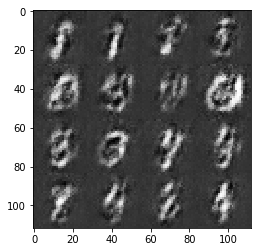

Epoch 1/2... Discriminator Loss: 0.2179... Generator Loss: 2.3207
Epoch 1/2... Discriminator Loss: 0.1741... Generator Loss: 3.3361
Epoch 1/2... Discriminator Loss: 0.1547... Generator Loss: 2.5878
Epoch 2/2... Discriminator Loss: 0.1423... Generator Loss: 2.5820
Epoch 2/2... Discriminator Loss: 0.1421... Generator Loss: 3.0519
Epoch 2/2... Discriminator Loss: 0.1304... Generator Loss: 3.3905
Epoch 2/2... Discriminator Loss: 0.1688... Generator Loss: 2.7827
Epoch 2/2... Discriminator Loss: 0.5929... Generator Loss: 1.0349
Epoch 2/2... Discriminator Loss: 0.1934... Generator Loss: 2.2674
Epoch 2/2... Discriminator Loss: 0.2130... Generator Loss: 2.2496


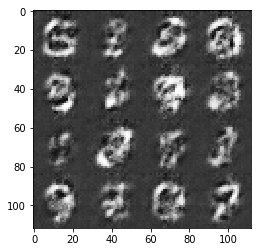

Epoch 2/2... Discriminator Loss: 0.1673... Generator Loss: 3.0716
Epoch 2/2... Discriminator Loss: 0.1726... Generator Loss: 2.4463
Epoch 2/2... Discriminator Loss: 0.1954... Generator Loss: 2.2451
Epoch 2/2... Discriminator Loss: 0.1423... Generator Loss: 2.8697
Epoch 2/2... Discriminator Loss: 0.1237... Generator Loss: 2.8743
Epoch 2/2... Discriminator Loss: 0.1125... Generator Loss: 3.0440
Epoch 2/2... Discriminator Loss: 2.2800... Generator Loss: 0.1547
Epoch 2/2... Discriminator Loss: 0.2440... Generator Loss: 2.1964
Epoch 2/2... Discriminator Loss: 0.1458... Generator Loss: 2.5976
Epoch 2/2... Discriminator Loss: 0.2014... Generator Loss: 3.1512


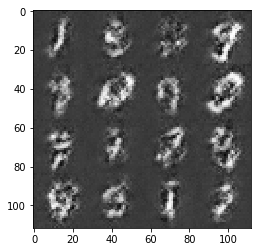

Epoch 2/2... Discriminator Loss: 0.1223... Generator Loss: 2.8007
Epoch 2/2... Discriminator Loss: 0.1461... Generator Loss: 2.5544
Epoch 2/2... Discriminator Loss: 0.1284... Generator Loss: 3.0406
Epoch 2/2... Discriminator Loss: 0.1239... Generator Loss: 2.8133
Epoch 2/2... Discriminator Loss: 0.1216... Generator Loss: 2.9778
Epoch 2/2... Discriminator Loss: 0.1327... Generator Loss: 3.2157
Epoch 2/2... Discriminator Loss: 0.1302... Generator Loss: 3.2328
Epoch 2/2... Discriminator Loss: 0.1734... Generator Loss: 2.3506
Epoch 2/2... Discriminator Loss: 0.0943... Generator Loss: 3.6513
Epoch 2/2... Discriminator Loss: 0.0880... Generator Loss: 3.3218


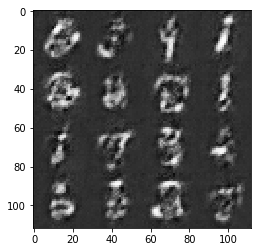

Epoch 2/2... Discriminator Loss: 0.1160... Generator Loss: 3.1584
Epoch 2/2... Discriminator Loss: 0.1203... Generator Loss: 2.8631
Epoch 2/2... Discriminator Loss: 0.2335... Generator Loss: 2.0603
Epoch 2/2... Discriminator Loss: 0.1737... Generator Loss: 2.3420
Epoch 2/2... Discriminator Loss: 0.1133... Generator Loss: 3.0494
Epoch 2/2... Discriminator Loss: 0.1224... Generator Loss: 2.9622
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 1.3268
Epoch 2/2... Discriminator Loss: 0.3397... Generator Loss: 1.7623
Epoch 2/2... Discriminator Loss: 0.2487... Generator Loss: 2.1789


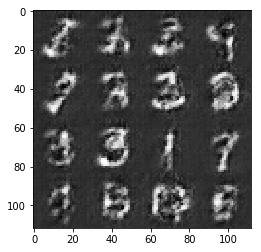

Epoch 2/2... Discriminator Loss: 0.1530... Generator Loss: 2.5793
Epoch 2/2... Discriminator Loss: 0.2179... Generator Loss: 2.0200
Epoch 2/2... Discriminator Loss: 0.1331... Generator Loss: 2.6036
Epoch 2/2... Discriminator Loss: 0.1620... Generator Loss: 2.5218
Epoch 2/2... Discriminator Loss: 0.1346... Generator Loss: 2.6455
Epoch 2/2... Discriminator Loss: 0.1079... Generator Loss: 2.8489
Epoch 2/2... Discriminator Loss: 0.0798... Generator Loss: 3.2206
Epoch 2/2... Discriminator Loss: 0.1092... Generator Loss: 2.8725
Epoch 2/2... Discriminator Loss: 0.1298... Generator Loss: 2.6753
Epoch 2/2... Discriminator Loss: 0.1621... Generator Loss: 2.4874


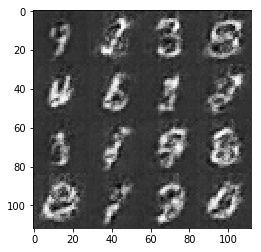

Epoch 2/2... Discriminator Loss: 0.0724... Generator Loss: 3.4975
Epoch 2/2... Discriminator Loss: 0.1472... Generator Loss: 2.4785
Epoch 2/2... Discriminator Loss: 0.1137... Generator Loss: 3.1815
Epoch 2/2... Discriminator Loss: 0.0609... Generator Loss: 3.4046
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 0.0989... Generator Loss: 2.9151
Epoch 2/2... Discriminator Loss: 0.1027... Generator Loss: 2.8708
Epoch 2/2... Discriminator Loss: 0.1298... Generator Loss: 2.5998
Epoch 2/2... Discriminator Loss: 0.0837... Generator Loss: 3.2896
Epoch 2/2... Discriminator Loss: 0.0339... Generator Loss: 4.2790


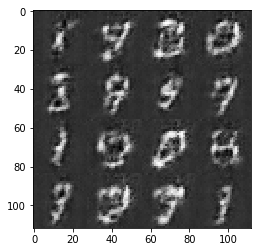

Epoch 2/2... Discriminator Loss: 0.0975... Generator Loss: 3.0309
Epoch 2/2... Discriminator Loss: 0.1154... Generator Loss: 2.7339
Epoch 2/2... Discriminator Loss: 0.0912... Generator Loss: 3.1975
Epoch 2/2... Discriminator Loss: 0.0606... Generator Loss: 3.7884
Epoch 2/2... Discriminator Loss: 0.0589... Generator Loss: 3.4874
Epoch 2/2... Discriminator Loss: 0.1043... Generator Loss: 2.9507
Epoch 2/2... Discriminator Loss: 0.0929... Generator Loss: 3.2848
Epoch 2/2... Discriminator Loss: 0.1231... Generator Loss: 2.8264
Epoch 2/2... Discriminator Loss: 0.0959... Generator Loss: 3.7898
Epoch 2/2... Discriminator Loss: 0.0691... Generator Loss: 4.1837


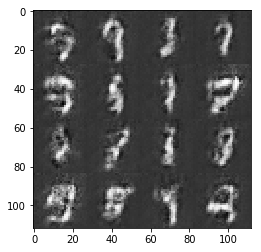

Epoch 2/2... Discriminator Loss: 0.1562... Generator Loss: 2.3776
Epoch 2/2... Discriminator Loss: 0.1411... Generator Loss: 2.4807
Epoch 2/2... Discriminator Loss: 0.0774... Generator Loss: 3.2747
Epoch 2/2... Discriminator Loss: 0.0964... Generator Loss: 3.3366
Epoch 2/2... Discriminator Loss: 0.1337... Generator Loss: 2.4547
Epoch 2/2... Discriminator Loss: 0.0602... Generator Loss: 3.4502
Epoch 2/2... Discriminator Loss: 0.0980... Generator Loss: 2.8886
Epoch 2/2... Discriminator Loss: 0.0764... Generator Loss: 3.1750
Epoch 2/2... Discriminator Loss: 0.0464... Generator Loss: 4.0867
Epoch 2/2... Discriminator Loss: 0.1267... Generator Loss: 2.6329


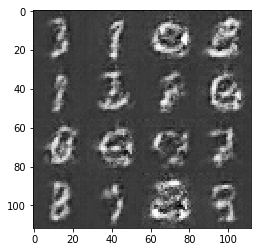

Epoch 2/2... Discriminator Loss: 0.1498... Generator Loss: 2.2824
Epoch 2/2... Discriminator Loss: 0.0913... Generator Loss: 3.1006
Epoch 2/2... Discriminator Loss: 8.2661... Generator Loss: 0.0008
Epoch 2/2... Discriminator Loss: 0.5187... Generator Loss: 1.5041
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 1.7772
Epoch 2/2... Discriminator Loss: 0.2361... Generator Loss: 2.0093
Epoch 2/2... Discriminator Loss: 0.3381... Generator Loss: 1.6089
Epoch 2/2... Discriminator Loss: 0.1241... Generator Loss: 3.0685
Epoch 2/2... Discriminator Loss: 0.1049... Generator Loss: 2.9005
Epoch 2/2... Discriminator Loss: 0.2040... Generator Loss: 2.0736


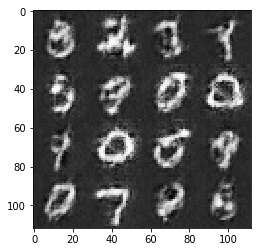

Epoch 2/2... Discriminator Loss: 0.1452... Generator Loss: 2.4711
Epoch 2/2... Discriminator Loss: 0.2099... Generator Loss: 2.3253
Epoch 2/2... Discriminator Loss: 0.1037... Generator Loss: 2.7098
Epoch 2/2... Discriminator Loss: 0.1113... Generator Loss: 2.9010
Epoch 2/2... Discriminator Loss: 0.1430... Generator Loss: 2.5504
Epoch 2/2... Discriminator Loss: 0.1798... Generator Loss: 2.1050
Epoch 2/2... Discriminator Loss: 0.1082... Generator Loss: 2.7808


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4801... Generator Loss: 0.1279
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 1.5668
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 0.2981... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 0.3252... Generator Loss: 1.8051
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 1.9441
Epoch 1/1... Discriminator Loss: 0.3061... Generator Loss: 1.9277


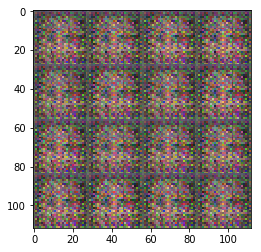

Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 1.7372
Epoch 1/1... Discriminator Loss: 0.2417... Generator Loss: 2.1757
Epoch 1/1... Discriminator Loss: 0.2362... Generator Loss: 2.1679
Epoch 1/1... Discriminator Loss: 0.2332... Generator Loss: 2.3670
Epoch 1/1... Discriminator Loss: 0.2637... Generator Loss: 2.2106
Epoch 1/1... Discriminator Loss: 0.1622... Generator Loss: 2.4984
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 2.7925
Epoch 1/1... Discriminator Loss: 0.2203... Generator Loss: 2.5677
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 1.5923
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 1.7388


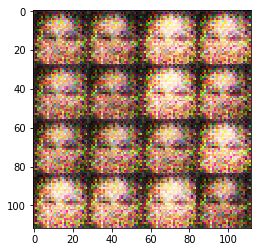

Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 1.6952
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 1.9119
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 1.9752
Epoch 1/1... Discriminator Loss: 0.2431... Generator Loss: 2.1210
Epoch 1/1... Discriminator Loss: 0.2904... Generator Loss: 1.9823
Epoch 1/1... Discriminator Loss: 0.2861... Generator Loss: 1.9661
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 1.9326
Epoch 1/1... Discriminator Loss: 0.3127... Generator Loss: 1.6868
Epoch 1/1... Discriminator Loss: 0.2450... Generator Loss: 1.9546
Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 2.6206


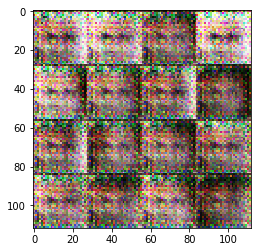

Epoch 1/1... Discriminator Loss: 0.2347... Generator Loss: 2.0285
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 2.6111
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 2.3957
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 2.6821
Epoch 1/1... Discriminator Loss: 0.2456... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 0.2002... Generator Loss: 1.9584
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 2.4545
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 2.7425
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.1348


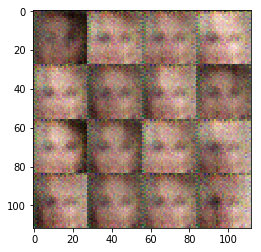

Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.8660
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.3002
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.3267
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.4164
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.3902
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.2988


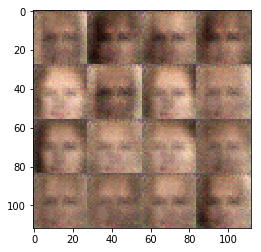

Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 1.5896
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.3212
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.1967


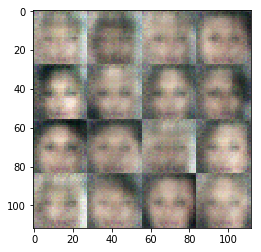

Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.3710
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.0639


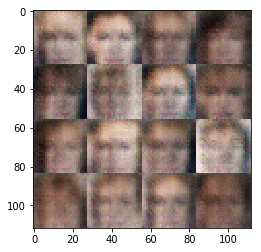

Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.4913
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.3319


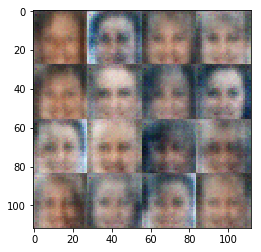

Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 2.7503
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 2.0705
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 3.0032
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 2.6947
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 1.2186


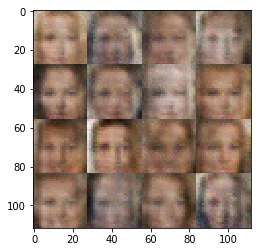

Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 2.2255
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 1.8558
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 3.7995
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 2.1465... Generator Loss: 0.1633
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 0.9095


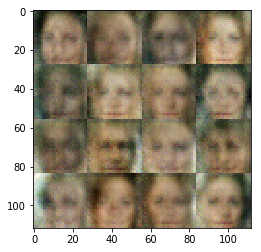

Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.8387
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 1.7849
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.2044


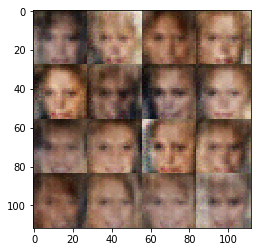

Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.8284
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 1.8823
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 1.8513
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 2.1807


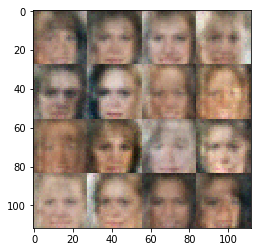

Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 2.7576
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 2.6812
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 1.5524
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 2.0285
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.6713


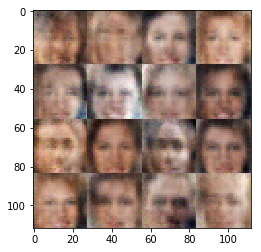

Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 2.4481
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 3.1816
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 2.2789
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 2.3642
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 1.9812
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 0.8944


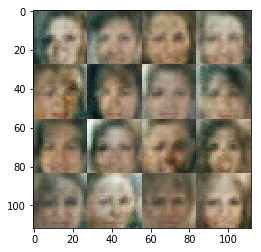

Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 3.0333
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 2.3337
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.5455
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 1.6792
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 1.7913
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 1.4206


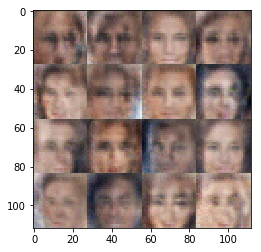

Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 1.5595
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 1.3858
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 2.2917
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 2.5913
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.0195
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 3.8369
Epoch 1/1... Discriminator Loss: 2.0056... Generator Loss: 4.2889


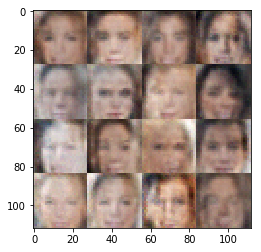

Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 1.8837
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 2.0760
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 3.0357
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 2.7171
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 2.7213
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 0.3663... Generator Loss: 2.5591


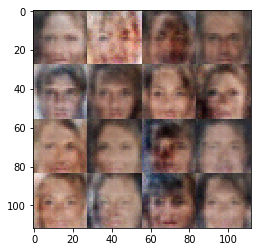

Epoch 1/1... Discriminator Loss: 0.2639... Generator Loss: 2.3930
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 2.6646
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 2.7132
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 1.6947
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 1.8857
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 3.8958
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 1.3297
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 2.0888
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 1.4828


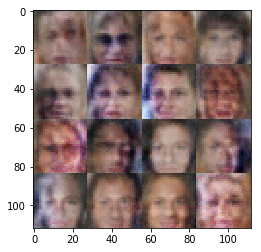

Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 4.1261
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 2.0578
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 2.1071
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 1.9600
Epoch 1/1... Discriminator Loss: 0.3209... Generator Loss: 2.4968
Epoch 1/1... Discriminator Loss: 0.1496... Generator Loss: 3.4544
Epoch 1/1... Discriminator Loss: 0.3181... Generator Loss: 2.2445
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 3.0482
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 3.1624
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.1315


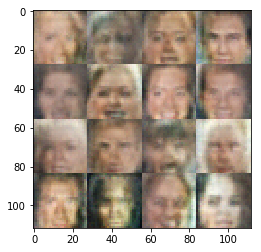

Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 1.5249
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 2.9631
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 2.9626
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 2.1430
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 3.0348
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 1.6196
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 0.5842


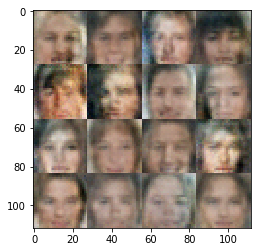

Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 2.8657
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 3.5606
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 1.5472


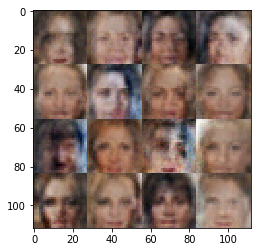

Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 1.7809
Epoch 1/1... Discriminator Loss: 0.2644... Generator Loss: 2.3370
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 1.4544
Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 2.8835
Epoch 1/1... Discriminator Loss: 0.3316... Generator Loss: 2.7774
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 3.8412
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 2.1967
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 1.8574
Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 1.5159


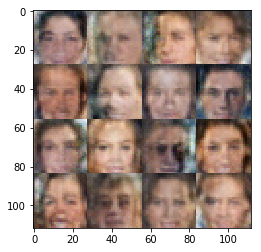

Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 3.7221
Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 1.7773
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.6896... Generator Loss: 0.2663
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 2.7820


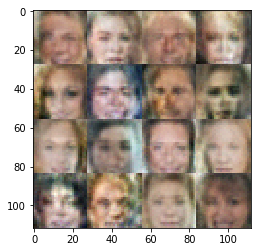

Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.1847
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 2.5199
Epoch 1/1... Discriminator Loss: 0.2880... Generator Loss: 1.9566
Epoch 1/1... Discriminator Loss: 0.2310... Generator Loss: 3.6906
Epoch 1/1... Discriminator Loss: 0.2750... Generator Loss: 2.9554
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 1.7198
Epoch 1/1... Discriminator Loss: 0.3175... Generator Loss: 2.1274
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 2.6212
Epoch 1/1... Discriminator Loss: 0.2690... Generator Loss: 2.8708
Epoch 1/1... Discriminator Loss: 0.3067... Generator Loss: 2.9912


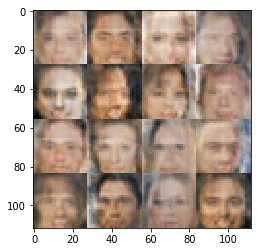

Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 0.2740... Generator Loss: 2.8792
Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 2.5408
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 1.7294
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 3.2952
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.7785
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 0.3152... Generator Loss: 2.2051


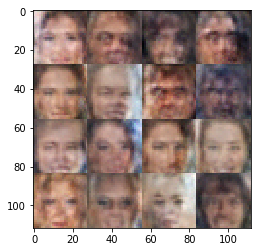

Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.7121
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 2.7086... Generator Loss: 5.6735
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 1.7398
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 2.5874
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 2.5527
Epoch 1/1... Discriminator Loss: 0.2842... Generator Loss: 2.1366
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 0.7071


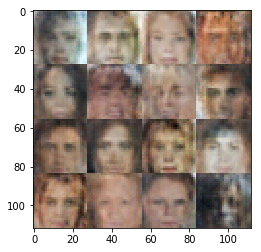

Epoch 1/1... Discriminator Loss: 0.2817... Generator Loss: 2.4471
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 1.7268
Epoch 1/1... Discriminator Loss: 0.2786... Generator Loss: 1.9558
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 1.7787
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.3795
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 1.9391
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 1.4986


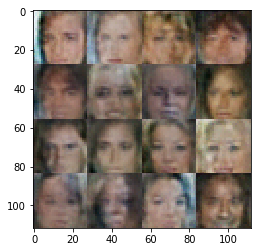

Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 2.2853
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 1.7798
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 1.7655
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 0.3060... Generator Loss: 2.1915
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 2.9268


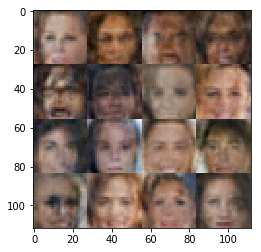

Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 2.0705
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 3.1441
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 1.8244
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 0.3160... Generator Loss: 2.5501
Epoch 1/1... Discriminator Loss: 0.2869... Generator Loss: 1.9633
Epoch 1/1... Discriminator Loss: 0.6148... Generator Loss: 2.0174
Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 1.8572


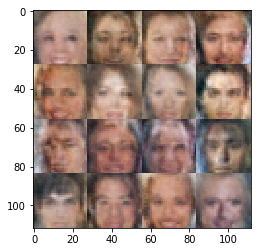

Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 2.3392
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 1.5603
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 3.1623
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 2.3285
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 1.9181
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 2.1697
Epoch 1/1... Discriminator Loss: 0.3166... Generator Loss: 1.7669


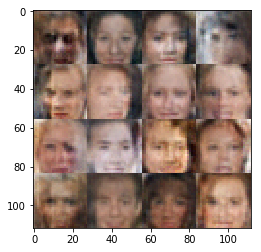

Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 2.6790
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.3844
Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 1.7046
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 1.5327
Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 2.1759
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 1.6881
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 1.7028


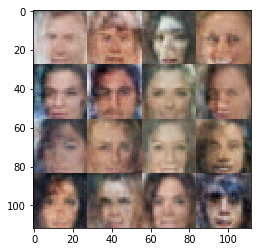

Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 2.6791
Epoch 1/1... Discriminator Loss: 0.2969... Generator Loss: 2.7502
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 0.9131


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.